# Quora QQP

### Word2vec

#### Performance Metrics


- Log Loss 
- Binary Confusion Matrix


- SGDClassifier
- XGBoost

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [42]:
# importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import nltk

from datetime import datetime
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss

import gensim
from gensim.models import Word2Vec

In [4]:
# importing the preprocessed dataset

df = pd.read_pickle("/content/drive/My Drive/questions_preprocessed.pkl")

In [5]:
df.head(10)

,question1,question2,is_duplicate,q1_len,q2_len,q1_word_len,q2_word_len,q1_char_len,q2_char_len,len_diff,word_len_diff,char_len_diff,common_words,common_words_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,step step guide invest share market india,step step guide invest share market,0,66,57,14,12,53,46,9,2,7,10,0.384615,92,100,92,100
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,51,88,8,13,44,76,37,5,32,4,0.190476,59,94,59,84
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,73,59,14,10,60,50,14,4,10,4,0.166667,55,56,70,70
3,mentally lonely solve,find remainder math2324math divided 2423,0,50,65,11,9,40,57,15,2,17,0,0.000000,23,29,23,23
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,76,39,13,7,64,33,37,6,31,2,0.100000,43,52,40,51
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1,86,90,16,16,71,75,4,0,4,8,0.250000,64,65,60,69
6,buy tiago,keeps childern active far phone video games,0,19,62,4,11,16,52,43,7,36,0,0.000000,19,33,19,19
7,good geologist,great geologist,1,30,41,7,9,24,33,11,2,9,4,0.250000,76,71,76,78
8,use shi instead shi,use instead,0,31,37,8,8,24,30,6,0,6,6,0.375000,73,82,73,100
9,motorola company hack charter motorolla dcx3400,hack motorola dcx3400 free internet,0,60,49,9,9,52,41,11,0,11,3,0.166667,51,60,59,75


In [6]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Word2vec

#### Word Mover's Distance (WMD)



In [8]:
question1, question2, is_dup = df.iloc[15, [0, 1, 2]].values
print('Question1: ', question1)
print('Question2: ', question2)
print('Is duplicate: ', is_dup)

question1 = question1.lower().split()
question2 = question2.lower().split()

question1 = [w for w in question1 if w not in stop_words]
question2 = [w for w in question2 if w not in stop_words]

Question1:  would trump presidency mean current international masters students f1 visa
Question2:  trump presidency affect students presently us planning study us
Is duplicate:  1


In [9]:
distance = model.wmdistance(question1, question2)
print('wmd distance = %.4f' % distance)

wmd distance = 2.2550


This question pair is labeled as duplicate, but the distance between these two sentences is pretty large. This brings us to normalized WMD.

## Normalizing word2vec

In [10]:
model.init_sims(replace=True)
distance = model.wmdistance(question1, question2)
print('normalized wmd distance = %.4f' % distance)

normalized wmd distance = 0.8665


In [11]:
question3, question4, is_dup = df.iloc[3, [0, 1, 2]].values
print('Question3: ', question3)
print('Question4: ', question4)
print('Is duplicate: ', is_dup)

question3 = question3.split()
question4 = question4.split()

question3 = [w for w in question3 if w not in stop_words]
question4 = [w for w in question4 if w not in stop_words]

Question3:  mentally lonely solve
Question4:  find remainder math2324math divided 2423
Is duplicate:  0


In [12]:
distance = model.wmdistance(question3, question4)
print('wmd distance = %.4f' % distance)

wmd distance = 1.2481


In [13]:
model.init_sims(replace=True)
distance = model.wmdistance(question3, question4)
print('normalized wmd distance = %.4f' % distance)

normalized wmd distance = 1.2481


## Cosine Similarity

In [14]:
from gensim import corpora
documents = [question1, question2, question3, question4]
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Convert the sentences into bag-of-words vectors.
question1 = dictionary.doc2bow(question1)
question2 = dictionary.doc2bow(question2)
question3 = dictionary.doc2bow(question3)
question4 = dictionary.doc2bow(question4)

In [15]:
import gensim.downloader as api

w2v_model = api.load("glove-wiki-gigaword-50")
similarity_matrix = w2v_model.similarity_matrix(dictionary)

[==================================================] 100.0% 66.0/66.0MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [16]:
from gensim.matutils import softcossim

similarity = softcossim(question1, question2, similarity_matrix)
print('similarity = %.4f' % similarity)

similarity = 0.7891


The similarity for the 1st pair is relative large, this means soft cosine thinks these two sentence are very similar.

In [17]:
similarity = softcossim(question3, question4, similarity_matrix)
print('similarity = %.4f' % similarity)

similarity = 0.2930


On the other hand, the similarity for the 2nd pair is very small, this means soft cosine thinks this pair are not similar.

### Word2vec 

In [18]:
# load word2vec model
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [19]:
df['wmd'] = df.apply(lambda x: model.wmdistance(x['question1'], x['question2']), axis=1)

## Normalized Word2vec

In [20]:
# load normalized word2vec model
norm_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [21]:
df['norm_wmd'] = df.apply(lambda x: norm_model.wmdistance(x['question1'], x['question2']), axis=1)

In [22]:
# list all column names

print(df.columns)

Index(['question1', 'question2', 'is_duplicate', 'q1_len', 'q2_len',
       'q1_word_len', 'q2_word_len', 'q1_char_len', 'q2_char_len', 'len_diff',
       'word_len_diff', 'char_len_diff', 'common_words', 'common_words_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio',
       'token_set_ratio', 'wmd', 'norm_wmd'],
      dtype='object')


In [23]:
df.head(10)

,question1,question2,is_duplicate,q1_len,q2_len,q1_word_len,q2_word_len,q1_char_len,q2_char_len,len_diff,word_len_diff,char_len_diff,common_words,common_words_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,wmd,norm_wmd
0,step step guide invest share market india,step step guide invest share market,0,66,57,14,12,53,46,9,2,7,10,0.384615,92,100,92,100,0.314466,0.113980
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,51,88,8,13,44,76,37,5,32,4,0.190476,59,94,59,84,0.817189,0.295074
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,73,59,14,10,60,50,14,4,10,4,0.166667,55,56,70,70,0.607675,0.205814
3,mentally lonely solve,find remainder math2324math divided 2423,0,50,65,11,9,40,57,15,2,17,0,0.000000,23,29,23,23,1.907965,0.763159
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,76,39,13,7,64,33,37,6,31,2,0.100000,43,52,40,51,1.019271,0.354407
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1,86,90,16,16,71,75,4,0,4,8,0.250000,64,65,60,69,0.567447,0.209981
6,buy tiago,keeps childern active far phone video games,0,19,62,4,11,16,52,43,7,36,0,0.000000,19,33,19,19,2.328187,0.813858
7,good geologist,great geologist,1,30,41,7,9,24,33,11,2,9,4,0.250000,76,71,76,78,0.649242,0.239367
8,use shi instead shi,use instead,0,31,37,8,8,24,30,6,0,6,6,0.375000,73,82,73,100,0.739701,0.274120
9,motorola company hack charter motorolla dcx3400,hack motorola dcx3400 free internet,0,60,49,9,9,52,41,11,0,11,3,0.166667,51,60,59,75,0.859735,0.311812


The following features are available for building the model:

- question1
- question2
- q1_len
- q2_len
- q1_word_len
- q1_word_len
- q1_char_len
- q1_char_len
- len_diff
- word_len_diff
- char_len_diff
- common_words
- common_words_ratio
- fuzz_ratio
- fuzz_partial_ratio
- token_sort_ratio
- token_set_ratio
- wmd
- norm_wmd

In [81]:
# save the wmd and normalized_wmd dataframe

pickle.dump(df, open('questions_word2vec.pkl', 'wb'))

In [73]:
# all features

X = df[['q1_len', 'q2_len', 'q1_word_len', 'q2_word_len', 'q1_char_len', 'q2_char_len', 'len_diff', 
        'word_len_diff', 'char_len_diff', 'common_words', 'common_words_ratio', 'fuzz_ratio', 
        'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'wmd', 'norm_wmd']]

# output feature: is_duplicate
y = df['is_duplicate']

In [75]:
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

In [78]:
# splitting the training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# plotting the confusion matrix

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

### SGDClassifier

In [82]:
start = datetime.utcnow()
alpha = [10 ** x for x in range(-5, 2)]

log_loss_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)
    log_loss_array.append(log_loss(y_test, y_pred_prob, labels=clf.classes_))
    print("For alpha={}, log loss is {}".format(i, log_loss_array[-1]))

print("Total running time: {}".format(datetime.utcnow() - start))

For alpha=1e-05, log loss is 1.7356797021065473
For alpha=0.0001, log loss is 0.5810974801287455
For alpha=0.001, log loss is 0.6898195956632347
For alpha=0.01, log loss is 0.5732506506601485
For alpha=0.1, log loss is 0.5444321922994311
For alpha=1, log loss is 0.5601030871813478
For alpha=10, log loss is 0.5815662160641676
Total running time: 0:02:17.104368


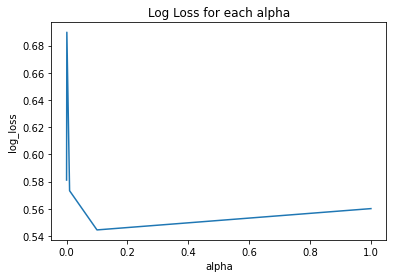

In [83]:
data_plot = pd.DataFrame(
    {"alpha": alpha[1:-1], "log_loss": log_loss_array[1:-1]})
sns.lineplot(x="alpha", y="log_loss", data=data_plot)
plt.title('Log Loss for each alpha')
plt.show()

In [84]:
clf = SGDClassifier(alpha=0.1, penalty='l2', loss='log', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

Log Loss (Training): 0.5484072770335439

Log Loss (Testing): 0.5444321922994311

Accuracy Score: 0.6722764931371337

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.79      0.75     51240
           1       0.56      0.46      0.51     29630

    accuracy                           0.67     80870
   macro avg       0.64      0.63      0.63     80870
weighted avg       0.66      0.67      0.66     80870


Confustion Matrix: 



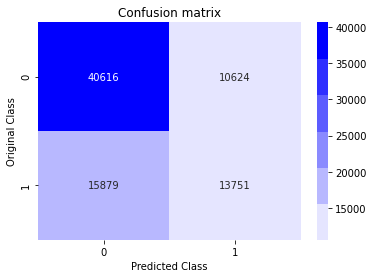

In [85]:
print("Log Loss (Training): {}\n".format(log_loss(y_train, clf.predict_proba(X_train))))
print("Log Loss (Testing): {}\n".format(log_loss(y_test, y_pred_prob, labels=clf.classes_)))
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
print('Classification Report:\n')
print(classification_report(y_test, y_pred))
print('\nConfustion Matrix: \n')
plot_confusion_matrix(y_test, y_pred)

### XGBClassifier 



In [86]:
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_jobs=-1, random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_prob = xgb_clf.predict_proba(X_test)
y_pred = xgb_clf.predict(X_test)

Log Loss (Training): 0.47433492069734146

Log Loss (Testing): 0.47069451128004214

Accuracy Score: 0.7338939037962161

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     51240
           1       0.61      0.74      0.67     29630

    accuracy                           0.73     80870
   macro avg       0.72      0.74      0.72     80870
weighted avg       0.75      0.73      0.74     80870


Confustion Matrix: 



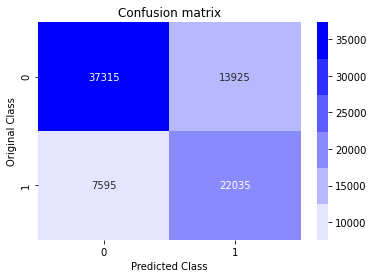

In [87]:
print("Log Loss (Training): {}\n".format(log_loss(y_train, xgb_clf.predict_proba(X_train))))
print("Log Loss (Testing): {}\n".format(log_loss(y_test, y_pred_prob, labels=clf.classes_)))
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
print('Classification Report:\n')
print(classification_report(y_test, y_pred))
print('\nConfustion Matrix: \n')
plot_confusion_matrix(y_test, y_pred)